# ML Facial recognition to detect mood and suggest songs accordingly

# Dataset link : https://www.kaggle.com/msambare/fer2013

In [1]:
#Import Libraries/Packages
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

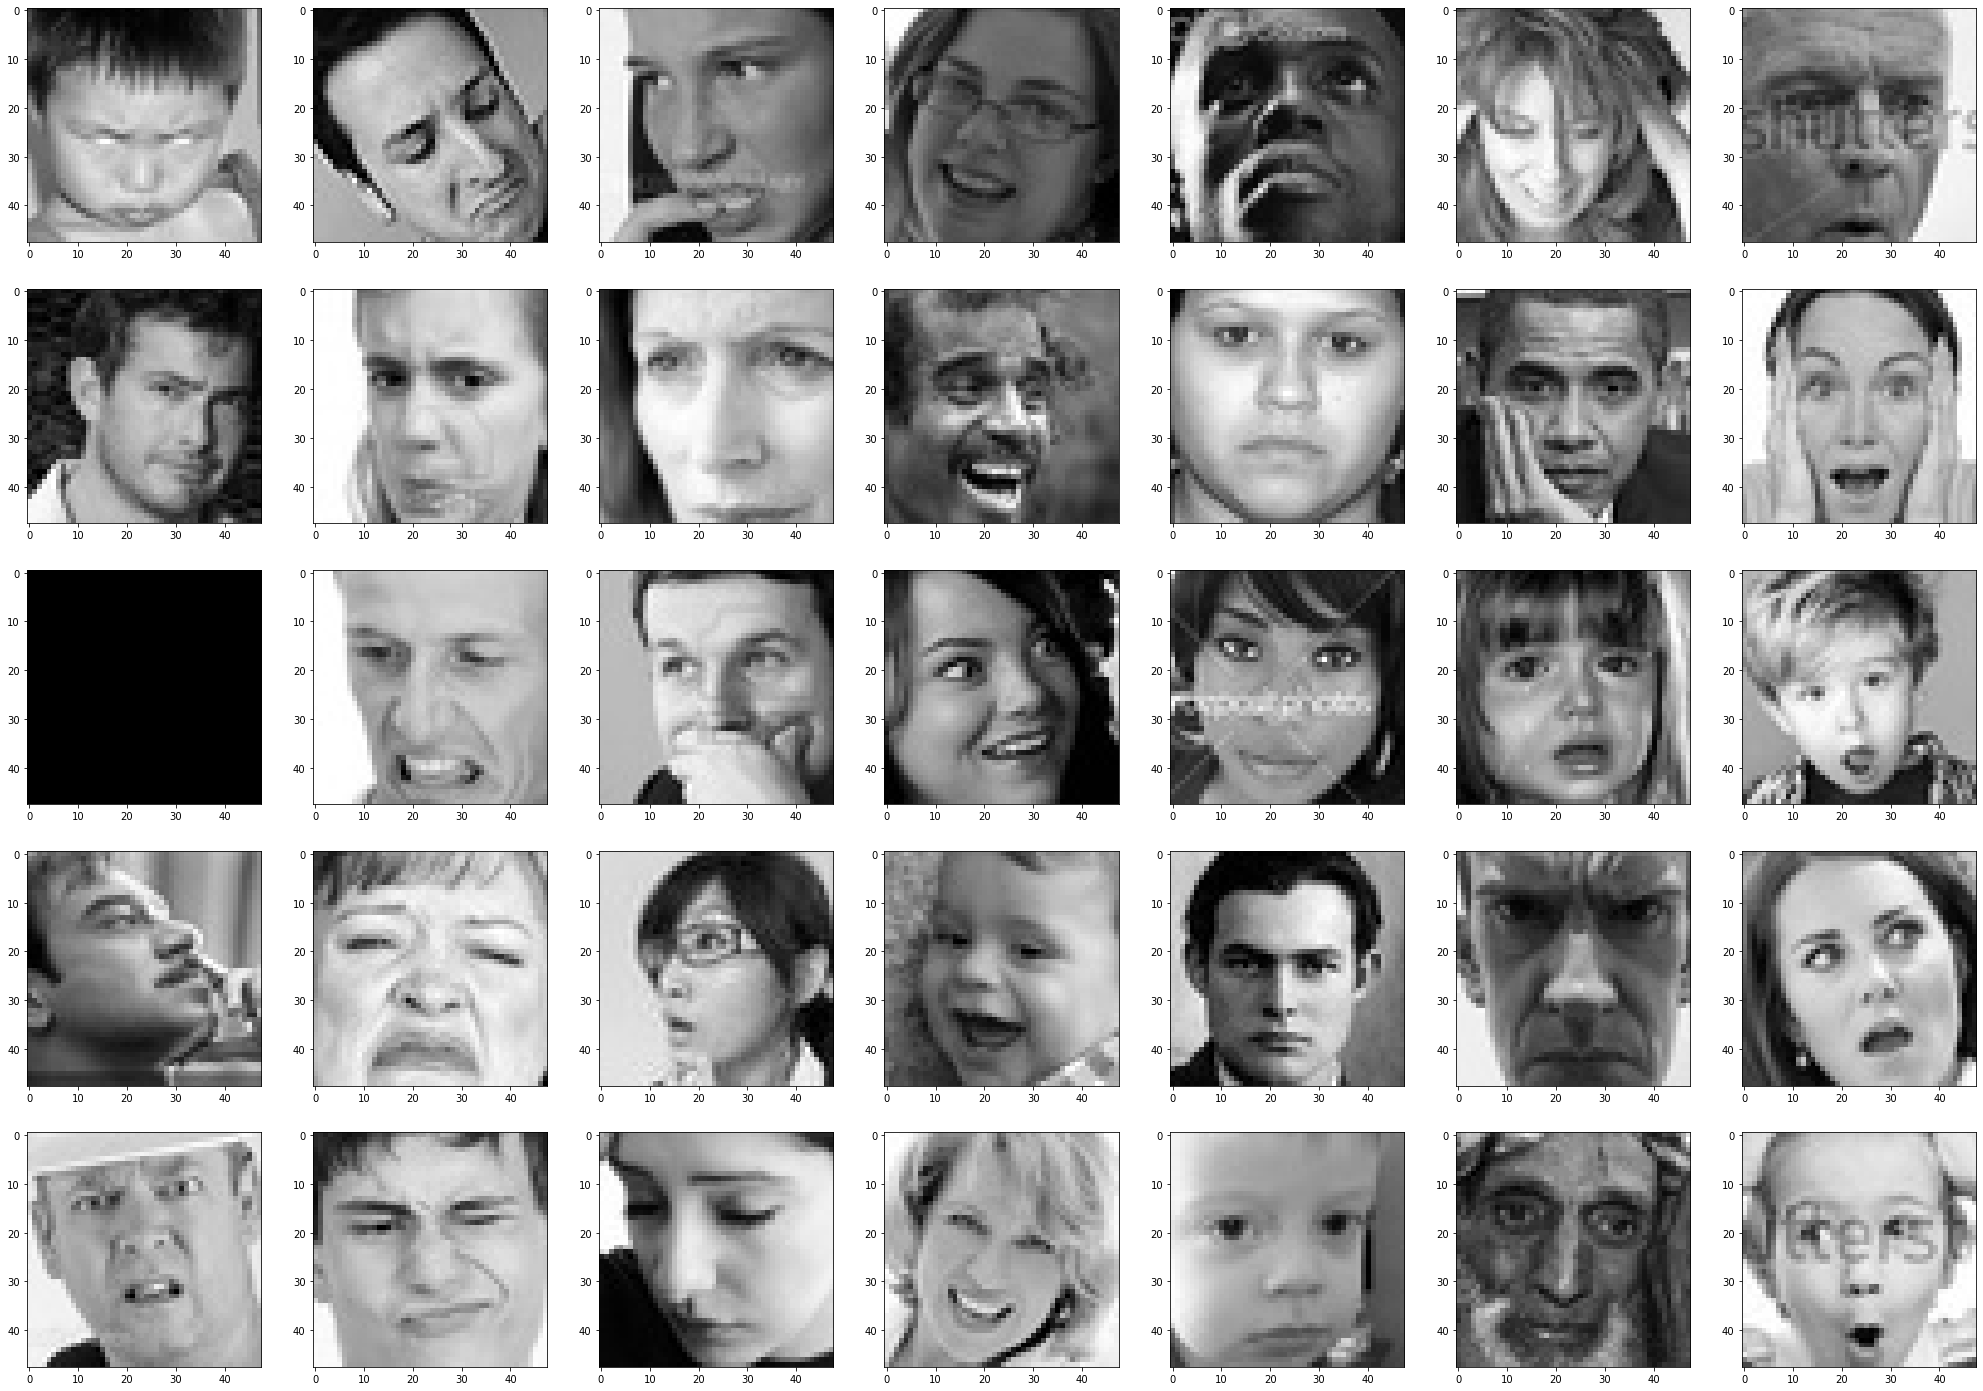

In [2]:
# Data Visualization
from skimage.io import imread
train_dir = "kaggle/train/"
test_dir = "kaggle/test/"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

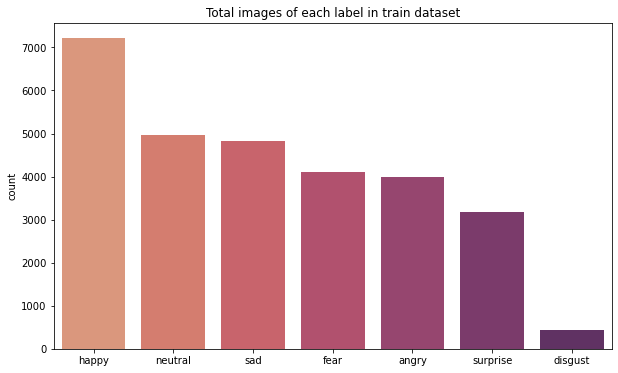

In [3]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=df.index, y="total", palette="flare", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

C:\Users\Madhu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


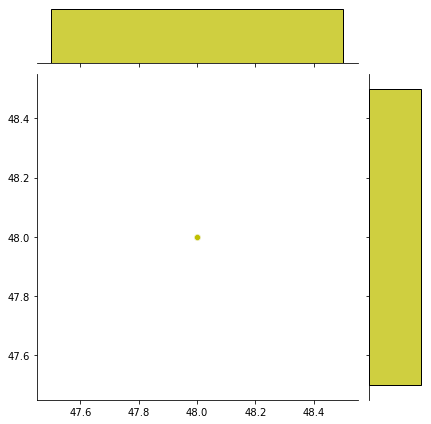

In [4]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(dim1, dim2,color='y')
plt.show()

In [5]:
# Data Preprocessing
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Creating the Model

In [6]:
# Create the Model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

Training the model

In [7]:
# Train the model
model.compile(optimizer=Adam(learning_rate=0.0001, 
                             decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [8]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 20

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - 769s 2s/step - loss: 1.8850 - accuracy: 0.2250 - val_loss: 2.2395 - val_accuracy: 0.2559
Epoch 2/20
448/448 [==============================] - 557s 1s/step - loss: 1.8046 - accuracy: 0.2418 - val_loss: 1.7973 - val_accuracy: 0.2704
Epoch 3/20
448/448 [==============================] - 529s 1s/step - loss: 1.7882 - accuracy: 0.2544 - val_loss: 1.8086 - val_accuracy: 0.2768
Epoch 4/20
448/448 [==============================] - 518s 1s/step - loss: 1.7770 - accuracy: 0.2647 - val_loss: 1.7186 - val_accuracy: 0.3068
Epoch 5/20
448/448 [==============================] - 513s 1s/step - loss: 1.7636 - accuracy: 0.2719 - val_loss: 1.6856 - val_accuracy: 0.3177
Epoch 6/20
448/448 [==============================] - 513s 1s/step - loss: 1.7418 - accuracy: 0.2879 - val_loss: 1.6201 - val_accuracy: 0.3513
Epoch 7/20
448/448 [==============================] - 512s 1s/step - loss: 1.7141 - accuracy: 0.3081 - val_loss: 1.7188 - val_accuracy: 0.3412

In [9]:
model.save("model.h5")

In [10]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 28s 232ms/step - loss: 1.1788 - accuracy: 0.5432
validation accuracy : 54.31874990463257%
validation loss : 1.1788359880447388


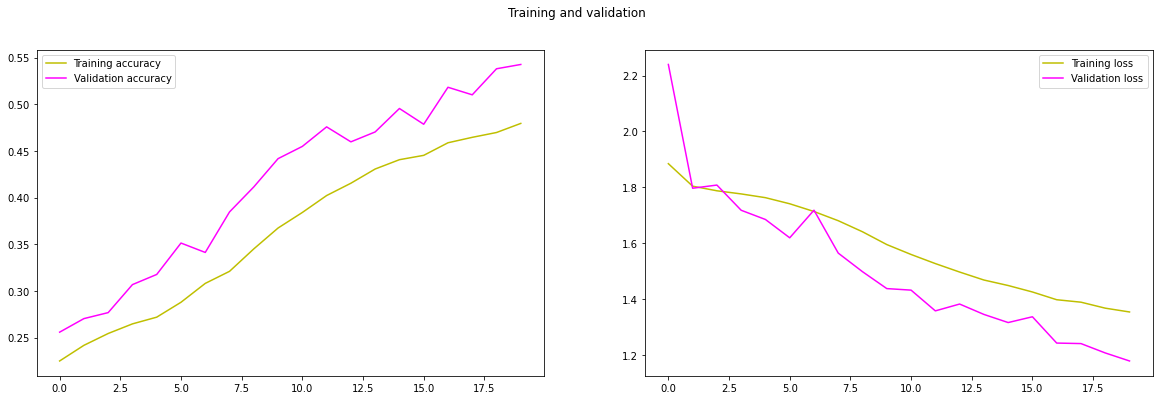

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'magenta', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'magenta', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

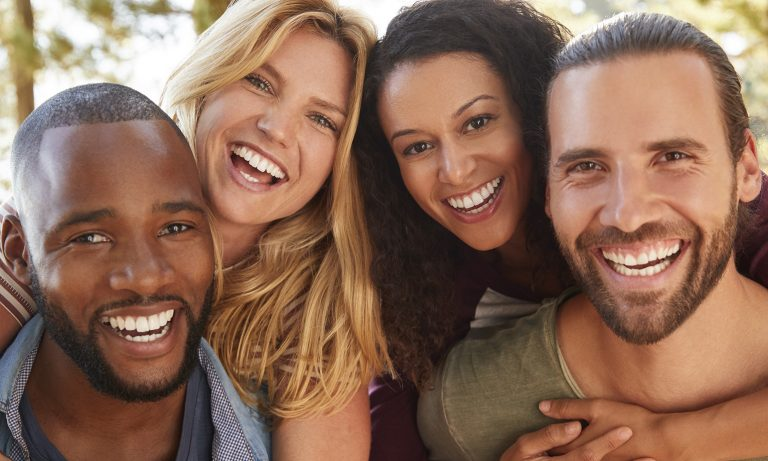

In [36]:
# Testing our model with new image
image = cv2.imread("images/happy.jpg")
from IPython.display import Image
Image(filename='images/happy.jpg')

In [38]:
# Model Prediction
import cv2
import tensorflow as tf
from tensorflow import keras
import os

# load weights
model.load_weights('model.h5')
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Surprise', 'Sad', 'Happy', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, and turn the grayscale image, normalization
frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reinvent the image dimension
gray = gray.reshape(1,48,48,1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The system considers this expression to be:",label)

  Angry   prediction rate is   0.07%
 Disgust  prediction rate is   0.00%
 Surprise prediction rate is   0.04%
   Sad    prediction rate is   0.28%
  Happy   prediction rate is   0.38%
 Neutral  prediction rate is   0.22%


 The system considers this expression to be: Happy


In [39]:
# Song Recommdation
if (label=='Angry'):
    path="song\\Angry\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Angry\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Disgust'):
    path="song\\Disgust\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Disgust\\'+ d,autoplay=True)
    display(audio)
    
elif (label=="Happy"):
    path="song\\Happy\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Happy\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Sad'):
    path="song\\Sad\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Sad\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Surprise'):
    path="song\\Surprise\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Surprise\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Neutral'):
    path="song\\Neutral\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Neutral\\'+ d,autoplay=True)
    display(audio)

Now Playing: happy.mp3


# THANK YOU!